## Premier League Match Predictor Model

In [1]:
from logging import warning
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import datetime as dt
import numpy as np
import sklearn
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.set_option('max_rows', None)
pd.set_option('max_columns', None)

In [49]:
df = pd.read_csv('epl_match_data_cleaned.csv')

In [50]:
pred_cols = list(df.columns[89:])
pred_cols.append('hour')
pred_cols.append('day_weekend')
pred_cols.append('is_home')

In [51]:
y = df['is_win']
x = df[pred_cols]

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
scalerStandard = StandardScaler()
scalerMinMax = MinMaxScaler()
x_scaled = pd.DataFrame(scalerMinMax.fit_transform(x))
x_scaled.columns = x.columns.values
x_scaled.index = x.index.values

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.25, random_state=47)

In [6]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

logreg = LogisticRegression()
rf = RandomForestClassifier()

rfecv = RFECV(estimator=logreg, step=1, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(x, y)

# rfe = RFE(logreg, 60)
# rfe = rfe.fit(x_train, y_train.values.ravel())

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=LogisticRegression(), scoring='accuracy')

Optimal number of features: 33


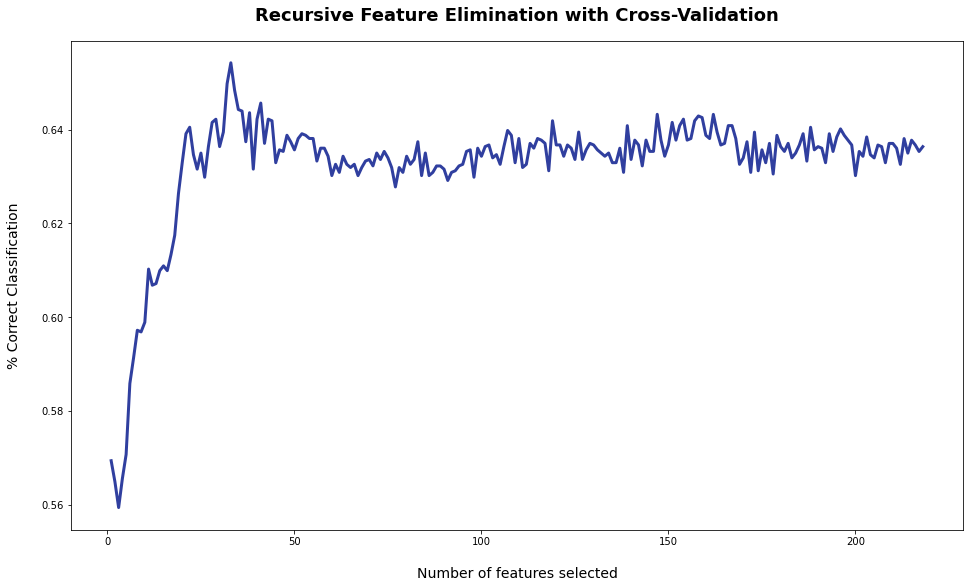

In [52]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [53]:
rfe_results = pd.DataFrame(data={'feature': list(x_train.columns), 'rfe_inclusion': list(rfecv.support_)})
rfe_features = list(rfe_results[rfe_results['rfe_inclusion'] == True]['feature'])

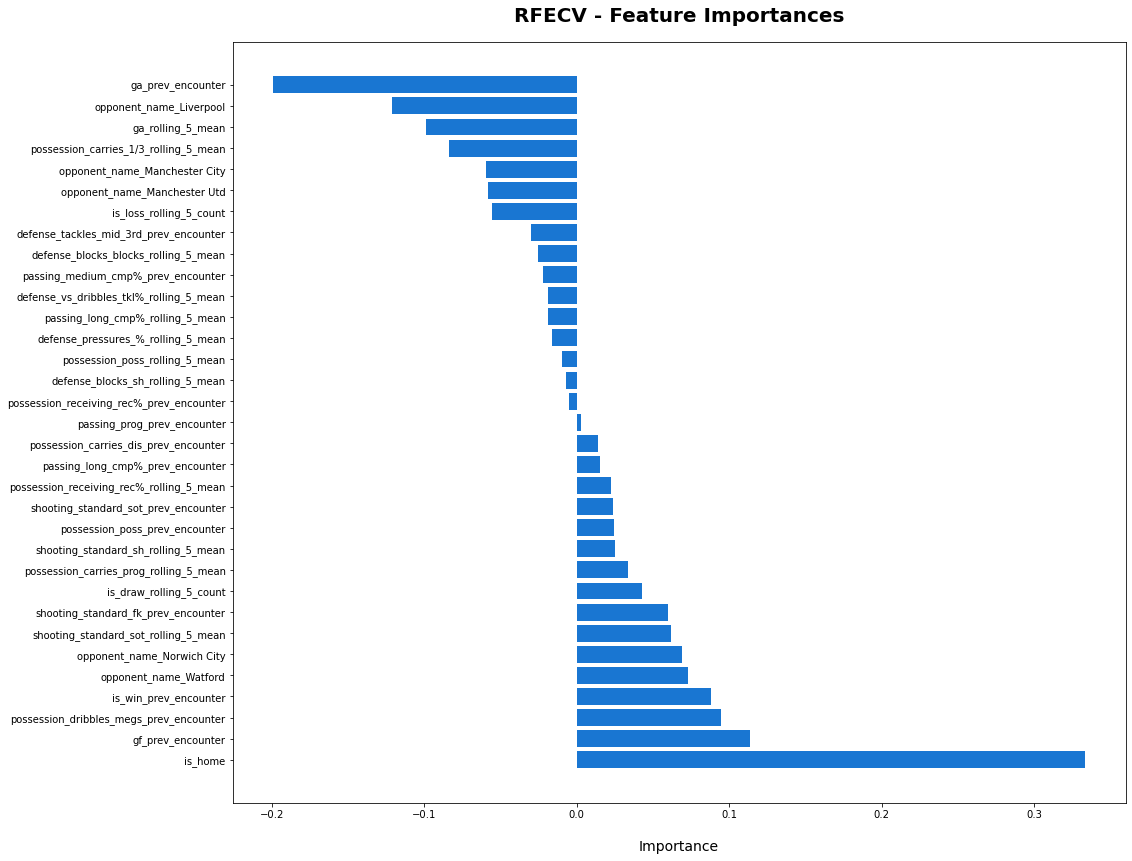

In [54]:
x_rfe = x[rfe_features]

dset = pd.DataFrame()
dset['attr'] = x_rfe.columns
dset['importance'] = rfecv.estimator_.coef_[0]

dset = dset.sort_values(by='importance', ascending=False)


plt.figure(figsize=(16, 14))
plt.barh(y=dset['attr'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Feature Importances', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

In [55]:
from sklearn import metrics

x_train = x_train[rfe_features]
x_test = x_test[rfe_features]

logreg.fit(x_train, y_train)

LogisticRegression()

In [56]:
y_pred = logreg.predict(x_test)
y_pred_a = logreg.predict_proba(x_test)

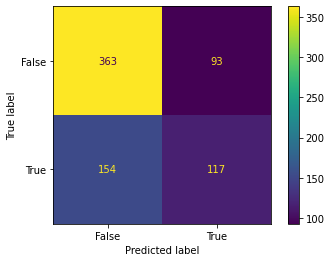

In [57]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [58]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print('accuracy: ' + str(accuracy_score(y_test, y_pred)))
print('precision: ' + str(precision_score(y_test, y_pred)))
print('recall: ' + str(recall_score(y_test, y_pred)))

accuracy: 0.6602475928473177
precision: 0.5571428571428572
recall: 0.4317343173431734


In [59]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.70      0.80      0.75       456
        True       0.56      0.43      0.49       271

    accuracy                           0.66       727
   macro avg       0.63      0.61      0.62       727
weighted avg       0.65      0.66      0.65       727



In [60]:
match_info = ['team','opponent','date']
matches = df[match_info]
combined = pd.DataFrame(dict(actual=y_test, predicted=y_pred, prob_win=y_pred_a[:,1]))
matches = matches.merge(combined, left_index=True, right_index=True)

matches = matches[(matches['prob_win'] > 0.8) | (matches['prob_win'] < 0.2)]
matches['accurate'] = (matches['actual'] == matches['predicted'])
matches.head(5)

,team,opponent,date,actual,predicted,prob_win,accurate
25,Arsenal,Liverpool,2018-12-29 17:30:00,False,False,0.110025,True
30,Arsenal,Manchester City,2019-02-03 16:30:00,False,False,0.123298,True
46,Arsenal,Liverpool,2019-08-24 17:30:00,False,False,0.137927,True
83,Arsenal,Manchester City,2020-10-17 17:30:00,False,False,0.064138,True
117,Arsenal,Manchester City,2021-08-28 12:30:00,False,False,0.154621,True
